# Sistemas Lineales<a class="tocSkip">
## TRATAMIENTO DE SEÑALES <a class="tocSkip">
### Ingenieria Electrónica <a class="tocSkip">
### Universidad Popular del Cesar <a class="tocSkip">
### Prof.: Jose Ramón Iglesias Gamarra - [https://github.com/joseramoniglesias/](https://github.com/joseramoniglesias/) <a class="tocSkip">
  **joseiglesias@unicesar.edu.co**

**Gabor Filters** are known best to depict the mammalian multi-channel approach of vision for interpreting and segmenting textures. This notebook shows an implementation of gabor filters in python using sklearn and other libraries to segment textures within an image. We will take an example of a slab image and segment the textures within the image using gabor filter. Our implementation shows three steps: pre-processing, gabor filter and post-processing.

Now lets begin with the required imports.

In [1]:
from PIL import Image, ImageEnhance
import numpy as np
from PIL import ImageFilter
import colorsys
import os
from skimage.filters import gabor, gaussian
from IPython.display import display 
from matplotlib.pyplot import imshow
from pywt import dwt2
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
#print(os.listdir("../input/"))
%matplotlib inline

First, we will get the example image and display it. 

(257, 163)


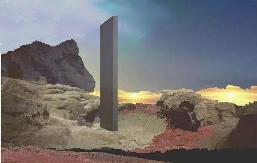

In [18]:
image1 = "Yatrides'_Slab.jpeg"
image = Image.open(image1).convert('RGB')
image_size = image.size
print(image_size)
display(image)

## Pre-processing

Enhace the color and brightness of the image. Then convert the image to gray scale.

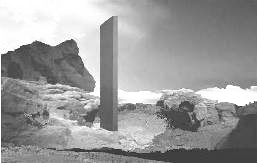

In [11]:
def enhance_brightness(image):
    """
    :param image: unenhanced image
    :return: Image with enhanced brightness. The new brightness is within the range of [0.3, 1] if the original brightness is greater than 0.1 else it is set to 0.1
    """
    mean_brightness = get_brightness(image)
    a, b = [0.3, 1]
    if mean_brightness<0.1:
        a = 0.1
    min_, max_ = [0, 1]
    new_brightness = (b - a) * (mean_brightness - min_) / (max_ - min_) + a
        
    brightness_factor = new_brightness/mean_brightness
    enhancer = ImageEnhance.Brightness(image)
    enhanced_image = enhancer.enhance(brightness_factor)
    return enhanced_image


def get_brightness(image):
    """
    :param image: unenhanced image
    :return: mean brightness of the image
    """
    brightness = []
    pixel_values = list(image.getdata())
    for values in pixel_values:
        R, G, B = values
        bright = np.sqrt(0.299 * R ** 2 + 0.587 * G ** 2 + 0.114 * B ** 2) / 255
        brightness.append(bright)
    return np.mean(brightness)

converter = ImageEnhance.Color(image)
image = converter.enhance(0.5) #enchance color by a factor of 0.5
image = enhance_brightness(image)
# convert to grayscale
image = image.convert('L')
display(image)

## Applying Gabor Filter

While applying gabor filters, we have to careful about the following three paramenters:
<ol>
<li>bandwidth</li>
<li>frequency</li>
<li>orientation</li>
</ol>


**Bandwidth**:
Narrower bandwidth is desirable because they make finer distinction in texture. In this implementation, we have determined the value of bandwidth using energy density of image. The higher the energy density, the lesser the bandwidth so that more textured areas do not overpower less textured areas. 

In [12]:
def get_image_energy(pixels):
    """
    :param pixels: image array
    :return: Energy content of the image
    """
    _, (cH, cV, cD) = dwt2(pixels.T, 'db1')
    energy = (cH ** 2 + cV ** 2 + cD ** 2).sum() / pixels.size
    return energy


def get_energy_density(pixels):
    """
    :param pixels: image array
    :param size: size of the image
    :return: Energy density of the image based on its size
    """
    energy = get_image_energy(pixels)
    energy_density = energy / (pixels.shape[0]*pixels.shape[1])
    return round(energy_density*100,5) # multiplying by 100 because the values are very small

pixels = np.asarray(image, dtype="int32")
energy_density = get_energy_density(pixels)
# get fixed bandwidth using energy density
bandwidth = abs(0.4*energy_density - 0.5)

In [14]:
# Convert to NumPy array
numpy_image = np.array(image)

    # Now you can access dtype
print(numpy_image.dtype)

uint8


**Theta**:
Theta represents the orientation of the gabor filter. In this implementation, we have used six orientations from 0 degree to 150 degree with a seperation of 30 degree each. Instead of this, we can also take an orientation seperation of 45 degree but, this would not produce as good results. 
<p>
**Frequency**:
According to this, for an orientation seperation of 30 degree, the total number of gabor filters required is: 6log2(Nc/2) where, Nc is the width of the image. The frequencies that should be used are:
1sqrt(2), 2sqrt(2), 4sqrt(2) ... Nc/4sqrt(2)<p>
However, in case of our image, we have experimentally chosen the following set of frequencies:
sqrt(2), 1+sqrt(2), 2+sqrt(2), 2sqrt(2)<p>
You can visualize the result of each gabor filter to decide for yourself.
<p>
Hence we have a total of 24 gabor filters.
<p>
The gabor filter gives a complex response. So we take the magnitude of the response for further processing. 

In [15]:
def get_magnitude(response):
    """
    :param response: original gabor response in the form: [real_part, imag_part] 
    :return: the magnitude response for the input gabor response
    """
    magnitude = np.array([np.sqrt(response[0][i][j]**2+response[1][i][j]**2)
                        for i in range(len(response[0])) for j in range(len(response[0][i]))])
    return magnitude

magnitude_dict = {}
for theta in np.arange(0, np.pi, np.pi / 6):
    for freq in np.array([1.4142135623730951, 2.414213562373095, 2.8284271247461903, 3.414213562373095]): 
        filt_real, filt_imag = gabor(numpy_image, frequency=freq, bandwidth=bandwidth, theta=theta)
        # get magnitude response
        magnitude = get_magnitude([filt_real, filt_imag])
        ''' uncomment the lines below to visualize each magnitude response '''
        # im = Image.fromarray(magnitude.reshape(image_size)).convert('L')
        # display(im)
        magnitude_dict[(theta, freq)] = magnitude.reshape(image.size)


## Post-processing

Now we have obtained the magnitude of 24 gabor filters. The next step is to smooth and reduce the magnitude array. We can apply gaussian smoothing to each of the magnitude response and then apply PCA to reduce the dimensions.  

In [16]:
def apply_pca(array):
    """
    :param array: array of shape pXd
    :return: reduced and transformed array of shape dX1
    """
    # apply dimensionality reduction to the input array
    standardized_data = StandardScaler().fit_transform(array)
    pca = PCA(n_components=1)
    pca.fit(standardized_data)
    transformed_data = pca.transform(standardized_data)
    return transformed_data

# apply gaussian smoothing
gabor_mag = []
for key, values in magnitude_dict.items():
    # the value of sigma is chosen to be half of the applied frequency
    sigma = 0.5*key[1]
    smoothed = gaussian(values, sigma = sigma)
    gabor_mag.append(smoothed)
gabor_mag = np.array(gabor_mag)

# reshape so that we can apply PCA
value = gabor_mag.reshape((-1, image_size[0]*image_size[1]))

# get dimensionally reduced image
pcaed = apply_pca(value.T).astype(np.uint8)
result = pcaed.reshape((image_size[0], image_size[1]))
result_im = Image.fromarray(result, mode='L')

**And here's the result**

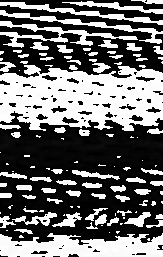

In [17]:
display(result_im)

You can further experiment with orientation, bandwidth and frequency values to get more suitable results. 

## References
1. https://www.mathworks.com/help/images/texture-segmentation-using-gabor-filters.html
<p>
2. https://pdfs.semanticscholar.org/a53b/78ff23daf515a344d47f4848e1f2528b3074.pdf

**Copyright**

The notebooks are provided as [Open Educational Resource](https://de.wikipedia.org/wiki/Open_Educational_Resources). Feel free to use the notebooks for your own educational purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT).